In [1]:
import os
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# PyTorch 4.1+
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn

% matplotlib inline

# Maximum Mean Discrepancy Variational Autoencoder (MMD-VAE)

This is a PyTorch implementation of the MMD-VAE, an Information-Maximizing Variational Autoencoder (InfoVAE). It is based off of the TensorFlow implementation published by the author of the original InfoVAE paper.

**References**:
 - https://arxiv.org/abs/1706.02262
 - https://github.com/ShengjiaZhao/MMD-Variational-Autoencoder
 - http://szhao.me/2017/06/10/a-tutorial-on-mmd-variational-autoencoders.html

In [2]:
CUDA = True

ZDIMS = 20
LR = 1e-3
EPOCHS = 30
BATCH_SIZE = 128
SEED = 4
LOG_INTERVAL = 100

In [3]:
torch.manual_seed(SEED)
device = torch.device('cuda' if CUDA else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
device

device(type='cuda')

## Data

In [4]:
# build train data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train = True,
                   download = True,
                   transform = transforms.ToTensor()),
    batch_size = BATCH_SIZE,
    shuffle = True,
    **kwargs
)

# build test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train = False,
                   transform = transforms.ToTensor()),
    batch_size = BATCH_SIZE,
    shuffle = True,
    **kwargs
)

## Model

In [5]:
NC = 1
NEF = 64
NDF = 64

class VAE(nn.Module):
    
    def __init__(self, zdims):
        super(VAE, self).__init__()
        
        self.zdims = zdims
        
        self.encoder = nn.Sequential(

            # input is (NC) x 28 x 28 (MNIST)
            nn.Conv2d(in_channels = NC, out_channels = NEF, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU(inplace = True),

            # conv layer 2
            # ( (14 - 4 + (2*1) ) / 2) + 1 = 7
            nn.Conv2d(in_channels = NEF, out_channels = NEF * 2, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(NEF * 2),
            nn.ReLU(inplace = True),

            # conv layer 3
            # ( (7 - 4 + (2*1) ) / 2) + 1 = 3
            nn.Conv2d(in_channels = NEF * 2, out_channels = NEF * 4, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(NEF * 4),
            nn.ReLU(inplace = True),

            # conv layer 4
            # ( (3 - 4 + (2*1) ) / 2) + 1 = 1
            nn.Conv2d(in_channels = NEF * 4, out_channels = 1024, kernel_size = 4, stride = 2, padding = 1),
            #nn.BatchNorm2d(1024), # OPTIONAL
            nn.ReLU(inplace = True)

        )

        self.decoder = nn.Sequential(

            # input is Z (post-fc)
            nn.ConvTranspose2d(in_channels = 1024, out_channels = NDF * 8, kernel_size = 4, stride = 1, padding = 0),
            nn.BatchNorm2d(NDF * 8),
            nn.ReLU(inplace = True),

            # deconv layer 2
            nn.ConvTranspose2d(in_channels = NDF * 8, out_channels = NDF * 4, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(NDF * 4),
            nn.ReLU(inplace = True),

            # deconv layer 3
            nn.ConvTranspose2d(in_channels = NDF * 4, out_channels = NDF * 2, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(NDF * 2),
            nn.ReLU(inplace = True),

            # deconv layer 4
            nn.ConvTranspose2d(in_channels = NDF * 2, out_channels = NC, kernel_size = 4, stride = 2, padding = 1),
            nn.Sigmoid()

        )
        
        # conv fc
        self.fc11 = nn.Linear(1024, self.zdims) # mu
        self.fc12 = nn.Linear(1024, self.zdims) # logvar
        
        # deconv fc
        self.fc2  = nn.Linear(self.zdims, 1024)
    
    
    def encode(self, x):
        conv = self.encoder(x)
        conv = conv.view(-1, 1024)
        mu = self.fc11(conv)
        logvar = self.fc12(conv)
        return mu, logvar
    
    def decode(self, z):
        deconv_input = F.relu(self.fc2(z))
        deconv_input = deconv_input.view(-1, 1024, 1, 1)
        recon_x = self.decoder(deconv_input)
        return recon_x
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar * 0.5)
        eps = torch.rand_like(std)
        z = eps.mul(std).add(mu)
        return z
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar, z

In [6]:
# init model
model = VAE(zdims = ZDIMS).to(device)
optimizer = optim.Adam(model.parameters(), lr = LR)

## Train Ops

In [7]:
'''
TensorFlow Implementation from Author
''''''

def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y, sigma_sqr=1.0):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

''';

In [9]:
# in-training sampling (plot / display)
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples

# compute kernel
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2) / float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

def loss_function(recon_x, x, z):
    true_samples = torch.randn(BATCH_SIZE, ZDIMS, requires_grad = False).to(device)
    mmd = compute_mmd(true_samples, z)
    nll = (recon_x - x).pow(2).mean()
    loss = nll + mmd
    return loss, nll, mmd

def train(epoch, show_samples = True):
    
    model.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, z = model(data)
        loss, nll, mmd = loss_function(recon_batch, data, z)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        # print progress
        if batch_idx % LOG_INTERVAL == 0:
            print("Train Epoch: {} | Negative Log Likelihood: {:.6f} | MMD Loss: {:.6f}".format(epoch,
                                                                                                nll.item(),
                                                                                                mmd.item())
                 )
    
    # generate samples
    if show_samples:
        gen_z = torch.randn(100, ZDIMS, requires_grad = False).to(device)
        samples = model.decode(gen_z)
        samples = samples.permute(0,2,3,1).contiguous().cpu().data.numpy()
        plt.imshow(convert_to_display(samples), cmap='Greys_r')
        plt.show()

def test(epoch):
    
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar, z = model(data)
            loss, _, __ = loss_function(recon_batch, data, z)
            test_loss += loss.item()
            
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])
                save_image(comparison.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow = n)
    
    test_loss /= len(test_loader.dataset)
    print('\n====> Test set loss: {:.8f}\n\n'.format(test_loss))

## Train Model

Train Epoch: 1 | Negative Log Likelihood: 0.242707 | MMD Loss: 0.027163
Train Epoch: 1 | Negative Log Likelihood: 0.049523 | MMD Loss: 0.002517
Train Epoch: 1 | Negative Log Likelihood: 0.025520 | MMD Loss: 0.004477
Train Epoch: 1 | Negative Log Likelihood: 0.017714 | MMD Loss: 0.002822
Train Epoch: 1 | Negative Log Likelihood: 0.014655 | MMD Loss: 0.002282


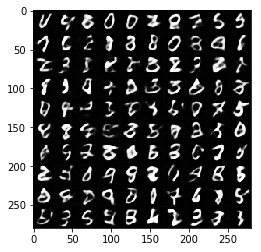


====> Test set loss: 0.00011852


Train Epoch: 2 | Negative Log Likelihood: 0.011810 | MMD Loss: 0.002900
Train Epoch: 2 | Negative Log Likelihood: 0.011751 | MMD Loss: 0.001764
Train Epoch: 2 | Negative Log Likelihood: 0.010250 | MMD Loss: 0.001980
Train Epoch: 2 | Negative Log Likelihood: 0.008862 | MMD Loss: 0.002676
Train Epoch: 2 | Negative Log Likelihood: 0.009156 | MMD Loss: 0.001817


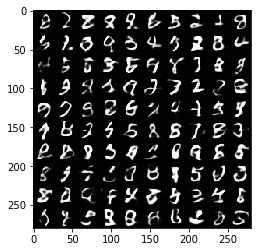


====> Test set loss: 0.00008563


Train Epoch: 3 | Negative Log Likelihood: 0.008123 | MMD Loss: 0.002394
Train Epoch: 3 | Negative Log Likelihood: 0.008186 | MMD Loss: 0.003272
Train Epoch: 3 | Negative Log Likelihood: 0.009260 | MMD Loss: 0.001563
Train Epoch: 3 | Negative Log Likelihood: 0.008035 | MMD Loss: 0.001791
Train Epoch: 3 | Negative Log Likelihood: 0.008178 | MMD Loss: 0.001099


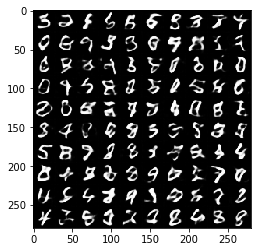


====> Test set loss: 0.00007534


Train Epoch: 4 | Negative Log Likelihood: 0.007864 | MMD Loss: 0.002180
Train Epoch: 4 | Negative Log Likelihood: 0.006824 | MMD Loss: 0.001384
Train Epoch: 4 | Negative Log Likelihood: 0.007524 | MMD Loss: 0.001493
Train Epoch: 4 | Negative Log Likelihood: 0.008023 | MMD Loss: 0.001449
Train Epoch: 4 | Negative Log Likelihood: 0.007057 | MMD Loss: 0.001865


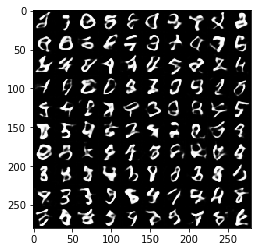


====> Test set loss: 0.00007044


Train Epoch: 5 | Negative Log Likelihood: 0.006575 | MMD Loss: 0.001465
Train Epoch: 5 | Negative Log Likelihood: 0.007084 | MMD Loss: 0.002121
Train Epoch: 5 | Negative Log Likelihood: 0.006106 | MMD Loss: 0.003282
Train Epoch: 5 | Negative Log Likelihood: 0.006101 | MMD Loss: 0.001977
Train Epoch: 5 | Negative Log Likelihood: 0.006701 | MMD Loss: 0.001213


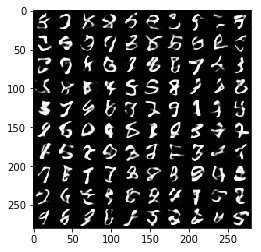


====> Test set loss: 0.00006950


Train Epoch: 6 | Negative Log Likelihood: 0.007211 | MMD Loss: 0.001062
Train Epoch: 6 | Negative Log Likelihood: 0.005932 | MMD Loss: 0.002133
Train Epoch: 6 | Negative Log Likelihood: 0.006842 | MMD Loss: 0.001454
Train Epoch: 6 | Negative Log Likelihood: 0.006064 | MMD Loss: 0.001893
Train Epoch: 6 | Negative Log Likelihood: 0.005434 | MMD Loss: 0.001238


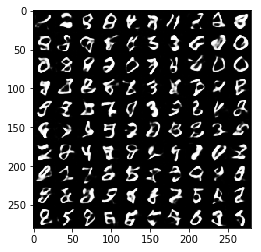


====> Test set loss: 0.00006327


Train Epoch: 7 | Negative Log Likelihood: 0.005399 | MMD Loss: 0.001625
Train Epoch: 7 | Negative Log Likelihood: 0.005307 | MMD Loss: 0.001594
Train Epoch: 7 | Negative Log Likelihood: 0.005680 | MMD Loss: 0.001936
Train Epoch: 7 | Negative Log Likelihood: 0.007271 | MMD Loss: 0.001680
Train Epoch: 7 | Negative Log Likelihood: 0.005695 | MMD Loss: 0.001836


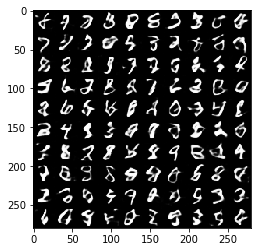


====> Test set loss: 0.00006194


Train Epoch: 8 | Negative Log Likelihood: 0.005433 | MMD Loss: 0.002111
Train Epoch: 8 | Negative Log Likelihood: 0.005582 | MMD Loss: 0.002103
Train Epoch: 8 | Negative Log Likelihood: 0.006012 | MMD Loss: 0.001625
Train Epoch: 8 | Negative Log Likelihood: 0.005363 | MMD Loss: 0.001871
Train Epoch: 8 | Negative Log Likelihood: 0.005246 | MMD Loss: 0.001525


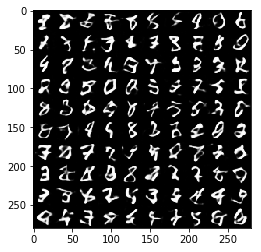


====> Test set loss: 0.00005894


Train Epoch: 9 | Negative Log Likelihood: 0.005254 | MMD Loss: 0.001570
Train Epoch: 9 | Negative Log Likelihood: 0.005038 | MMD Loss: 0.000779
Train Epoch: 9 | Negative Log Likelihood: 0.005984 | MMD Loss: 0.002244
Train Epoch: 9 | Negative Log Likelihood: 0.004999 | MMD Loss: 0.002931
Train Epoch: 9 | Negative Log Likelihood: 0.005133 | MMD Loss: 0.001654


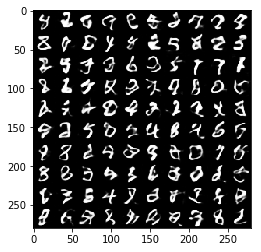


====> Test set loss: 0.00006115


Train Epoch: 10 | Negative Log Likelihood: 0.005080 | MMD Loss: 0.001725
Train Epoch: 10 | Negative Log Likelihood: 0.005009 | MMD Loss: 0.001381
Train Epoch: 10 | Negative Log Likelihood: 0.004959 | MMD Loss: 0.001181
Train Epoch: 10 | Negative Log Likelihood: 0.004755 | MMD Loss: 0.001274
Train Epoch: 10 | Negative Log Likelihood: 0.005509 | MMD Loss: 0.002463


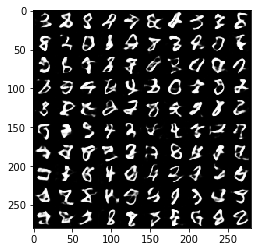


====> Test set loss: 0.00006194


Train Epoch: 11 | Negative Log Likelihood: 0.004955 | MMD Loss: 0.002511
Train Epoch: 11 | Negative Log Likelihood: 0.005032 | MMD Loss: 0.001978
Train Epoch: 11 | Negative Log Likelihood: 0.004870 | MMD Loss: 0.001990
Train Epoch: 11 | Negative Log Likelihood: 0.004642 | MMD Loss: 0.001602
Train Epoch: 11 | Negative Log Likelihood: 0.004691 | MMD Loss: 0.001316


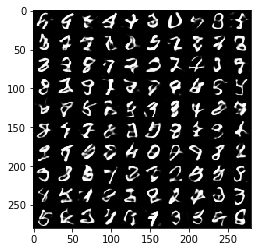


====> Test set loss: 0.00005477


Train Epoch: 12 | Negative Log Likelihood: 0.004720 | MMD Loss: 0.001971
Train Epoch: 12 | Negative Log Likelihood: 0.005227 | MMD Loss: 0.001485
Train Epoch: 12 | Negative Log Likelihood: 0.004864 | MMD Loss: 0.001711
Train Epoch: 12 | Negative Log Likelihood: 0.004785 | MMD Loss: 0.001302
Train Epoch: 12 | Negative Log Likelihood: 0.004777 | MMD Loss: 0.002138


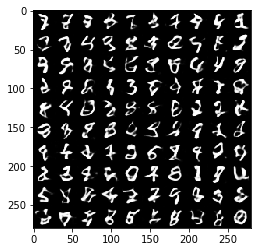


====> Test set loss: 0.00005836


Train Epoch: 13 | Negative Log Likelihood: 0.004737 | MMD Loss: 0.002178
Train Epoch: 13 | Negative Log Likelihood: 0.004783 | MMD Loss: 0.002056
Train Epoch: 13 | Negative Log Likelihood: 0.004929 | MMD Loss: 0.000864
Train Epoch: 13 | Negative Log Likelihood: 0.004690 | MMD Loss: 0.001338
Train Epoch: 13 | Negative Log Likelihood: 0.004290 | MMD Loss: 0.001040


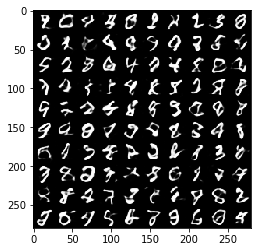


====> Test set loss: 0.00005693


Train Epoch: 14 | Negative Log Likelihood: 0.004611 | MMD Loss: 0.001728
Train Epoch: 14 | Negative Log Likelihood: 0.004449 | MMD Loss: 0.001032
Train Epoch: 14 | Negative Log Likelihood: 0.004614 | MMD Loss: 0.001343
Train Epoch: 14 | Negative Log Likelihood: 0.004226 | MMD Loss: 0.001061
Train Epoch: 14 | Negative Log Likelihood: 0.004132 | MMD Loss: 0.002397


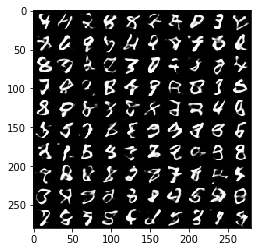


====> Test set loss: 0.00005519


Train Epoch: 15 | Negative Log Likelihood: 0.004387 | MMD Loss: 0.001222
Train Epoch: 15 | Negative Log Likelihood: 0.004812 | MMD Loss: 0.001192
Train Epoch: 15 | Negative Log Likelihood: 0.005124 | MMD Loss: 0.001013
Train Epoch: 15 | Negative Log Likelihood: 0.004333 | MMD Loss: 0.001983
Train Epoch: 15 | Negative Log Likelihood: 0.004559 | MMD Loss: 0.001158


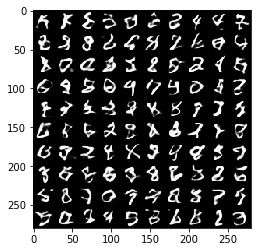


====> Test set loss: 0.00005539


Train Epoch: 16 | Negative Log Likelihood: 0.004104 | MMD Loss: 0.001755
Train Epoch: 16 | Negative Log Likelihood: 0.004570 | MMD Loss: 0.001765
Train Epoch: 16 | Negative Log Likelihood: 0.004256 | MMD Loss: 0.001530
Train Epoch: 16 | Negative Log Likelihood: 0.003678 | MMD Loss: 0.001048
Train Epoch: 16 | Negative Log Likelihood: 0.004223 | MMD Loss: 0.002103


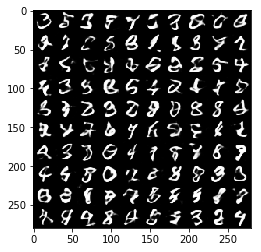


====> Test set loss: 0.00005761


Train Epoch: 17 | Negative Log Likelihood: 0.004140 | MMD Loss: 0.001334
Train Epoch: 17 | Negative Log Likelihood: 0.003834 | MMD Loss: 0.001222
Train Epoch: 17 | Negative Log Likelihood: 0.003811 | MMD Loss: 0.001948
Train Epoch: 17 | Negative Log Likelihood: 0.003534 | MMD Loss: 0.001916
Train Epoch: 17 | Negative Log Likelihood: 0.004087 | MMD Loss: 0.001551


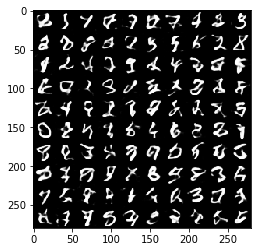


====> Test set loss: 0.00005416


Train Epoch: 18 | Negative Log Likelihood: 0.004097 | MMD Loss: 0.001251
Train Epoch: 18 | Negative Log Likelihood: 0.003834 | MMD Loss: 0.000997
Train Epoch: 18 | Negative Log Likelihood: 0.004427 | MMD Loss: 0.001465
Train Epoch: 18 | Negative Log Likelihood: 0.004408 | MMD Loss: 0.001698
Train Epoch: 18 | Negative Log Likelihood: 0.004374 | MMD Loss: 0.001340


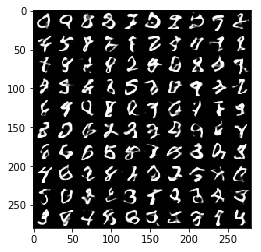


====> Test set loss: 0.00005315


Train Epoch: 19 | Negative Log Likelihood: 0.004916 | MMD Loss: 0.000976
Train Epoch: 19 | Negative Log Likelihood: 0.003804 | MMD Loss: 0.001750
Train Epoch: 19 | Negative Log Likelihood: 0.003584 | MMD Loss: 0.001329
Train Epoch: 19 | Negative Log Likelihood: 0.004297 | MMD Loss: 0.002230
Train Epoch: 19 | Negative Log Likelihood: 0.004288 | MMD Loss: 0.000600


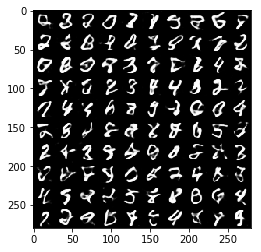


====> Test set loss: 0.00005416


Train Epoch: 20 | Negative Log Likelihood: 0.003972 | MMD Loss: 0.000694
Train Epoch: 20 | Negative Log Likelihood: 0.004047 | MMD Loss: 0.000995
Train Epoch: 20 | Negative Log Likelihood: 0.004198 | MMD Loss: 0.001221
Train Epoch: 20 | Negative Log Likelihood: 0.003909 | MMD Loss: 0.001166
Train Epoch: 20 | Negative Log Likelihood: 0.004034 | MMD Loss: 0.000707


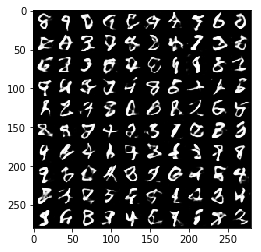


====> Test set loss: 0.00005841


Train Epoch: 21 | Negative Log Likelihood: 0.004109 | MMD Loss: 0.001257
Train Epoch: 21 | Negative Log Likelihood: 0.004323 | MMD Loss: 0.001459
Train Epoch: 21 | Negative Log Likelihood: 0.004068 | MMD Loss: 0.001472
Train Epoch: 21 | Negative Log Likelihood: 0.003832 | MMD Loss: 0.001181
Train Epoch: 21 | Negative Log Likelihood: 0.004436 | MMD Loss: 0.001287


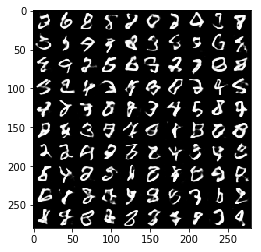


====> Test set loss: 0.00005218


Train Epoch: 22 | Negative Log Likelihood: 0.003472 | MMD Loss: 0.001253
Train Epoch: 22 | Negative Log Likelihood: 0.003579 | MMD Loss: 0.001002
Train Epoch: 22 | Negative Log Likelihood: 0.004029 | MMD Loss: 0.002273
Train Epoch: 22 | Negative Log Likelihood: 0.003833 | MMD Loss: 0.001477
Train Epoch: 22 | Negative Log Likelihood: 0.004534 | MMD Loss: 0.001251


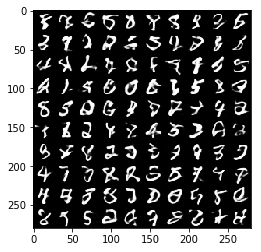


====> Test set loss: 0.00005403


Train Epoch: 23 | Negative Log Likelihood: 0.003783 | MMD Loss: 0.001459
Train Epoch: 23 | Negative Log Likelihood: 0.003660 | MMD Loss: 0.001165
Train Epoch: 23 | Negative Log Likelihood: 0.003684 | MMD Loss: 0.001483
Train Epoch: 23 | Negative Log Likelihood: 0.003878 | MMD Loss: 0.001385
Train Epoch: 23 | Negative Log Likelihood: 0.003679 | MMD Loss: 0.001762


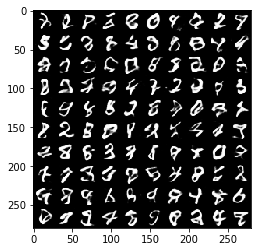


====> Test set loss: 0.00005261


Train Epoch: 24 | Negative Log Likelihood: 0.003657 | MMD Loss: 0.000963
Train Epoch: 24 | Negative Log Likelihood: 0.003670 | MMD Loss: 0.001197
Train Epoch: 24 | Negative Log Likelihood: 0.003736 | MMD Loss: 0.001694
Train Epoch: 24 | Negative Log Likelihood: 0.004177 | MMD Loss: 0.000748
Train Epoch: 24 | Negative Log Likelihood: 0.003983 | MMD Loss: 0.001225


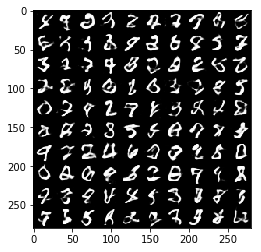


====> Test set loss: 0.00005210


Train Epoch: 25 | Negative Log Likelihood: 0.003641 | MMD Loss: 0.000702
Train Epoch: 25 | Negative Log Likelihood: 0.003606 | MMD Loss: 0.001568
Train Epoch: 25 | Negative Log Likelihood: 0.003817 | MMD Loss: 0.001281
Train Epoch: 25 | Negative Log Likelihood: 0.003655 | MMD Loss: 0.001424
Train Epoch: 25 | Negative Log Likelihood: 0.004118 | MMD Loss: 0.003182


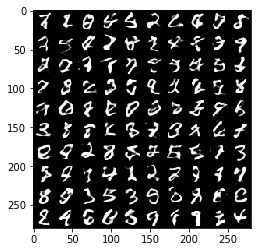


====> Test set loss: 0.00005073


Train Epoch: 26 | Negative Log Likelihood: 0.003229 | MMD Loss: 0.001174
Train Epoch: 26 | Negative Log Likelihood: 0.003201 | MMD Loss: 0.001506
Train Epoch: 26 | Negative Log Likelihood: 0.003594 | MMD Loss: 0.000986
Train Epoch: 26 | Negative Log Likelihood: 0.003710 | MMD Loss: 0.002386
Train Epoch: 26 | Negative Log Likelihood: 0.004055 | MMD Loss: 0.000781


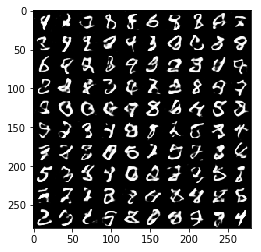


====> Test set loss: 0.00005051


Train Epoch: 27 | Negative Log Likelihood: 0.003325 | MMD Loss: 0.000761
Train Epoch: 27 | Negative Log Likelihood: 0.003632 | MMD Loss: 0.001140
Train Epoch: 27 | Negative Log Likelihood: 0.003801 | MMD Loss: 0.001467
Train Epoch: 27 | Negative Log Likelihood: 0.003516 | MMD Loss: 0.001437
Train Epoch: 27 | Negative Log Likelihood: 0.003715 | MMD Loss: 0.001311


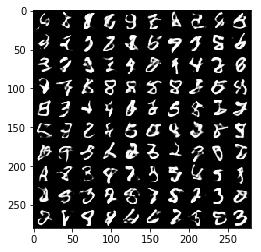


====> Test set loss: 0.00005207


Train Epoch: 28 | Negative Log Likelihood: 0.003352 | MMD Loss: 0.001653
Train Epoch: 28 | Negative Log Likelihood: 0.003248 | MMD Loss: 0.001122
Train Epoch: 28 | Negative Log Likelihood: 0.003388 | MMD Loss: 0.001367
Train Epoch: 28 | Negative Log Likelihood: 0.003376 | MMD Loss: 0.000497
Train Epoch: 28 | Negative Log Likelihood: 0.003622 | MMD Loss: 0.000888


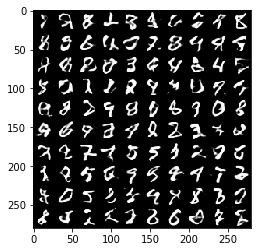


====> Test set loss: 0.00005177


Train Epoch: 29 | Negative Log Likelihood: 0.003770 | MMD Loss: 0.001334
Train Epoch: 29 | Negative Log Likelihood: 0.003345 | MMD Loss: 0.001146
Train Epoch: 29 | Negative Log Likelihood: 0.003309 | MMD Loss: 0.001045
Train Epoch: 29 | Negative Log Likelihood: 0.003390 | MMD Loss: 0.001580
Train Epoch: 29 | Negative Log Likelihood: 0.003844 | MMD Loss: 0.001128


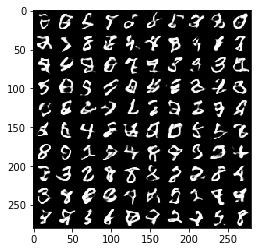


====> Test set loss: 0.00005112


Train Epoch: 30 | Negative Log Likelihood: 0.003495 | MMD Loss: 0.001104
Train Epoch: 30 | Negative Log Likelihood: 0.003408 | MMD Loss: 0.001860
Train Epoch: 30 | Negative Log Likelihood: 0.003203 | MMD Loss: 0.003010
Train Epoch: 30 | Negative Log Likelihood: 0.003657 | MMD Loss: 0.001392
Train Epoch: 30 | Negative Log Likelihood: 0.003230 | MMD Loss: 0.001083


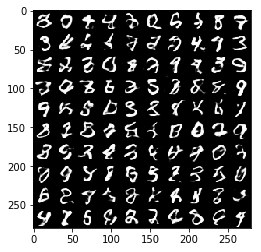


====> Test set loss: 0.00005438




In [10]:
# train model
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

# Results

In the author's tutorial and code, he shows that high-quality samples can be achieved with a minute of training on a subset of 500 images. Unfortunately, with additional training on the entire dataset, we begin to see similar over-fitting that he observes with a vanilla VAE.

Fortunately though, the MMD-VAE shows a much stronger ability to reconstruct x, with a test set reconstruction that is not blurry while still maintaining good generalization. And though it is not shown in this notebook, it's worth noting that when trained with fewer `z` dimensions (10 `z` dimensions produced the best results in my very limited testing), the samples generated were much more realistic and clear. This suggests that if this model were to be used for generative tasks, the quantity of `z` dimensions is an important parameter to tune.

In regard to dimension reduction, as with the vanilla (beta-) VAE, it's unclear how well the latent features are disentangled. Next I will use the latent vectors of the different VAE models created thus far (and at various beta levels, when applicable) to test the classification effectiveness/accuracy.